In [5]:
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import glob
import os

# Caminho da pasta
folder_path = "24-09-2025"  # Certifique-se de colocar o caminho correto
txt_files = glob.glob(os.path.join(folder_path, "*.txt"))

# Ler o conteúdo do arquivo
content = []
for file in txt_files:
    with open(file, "r") as f:
        content.extend(f.readlines())


In [6]:

# Converter tempo para formato numérico
def convert_time(time_str):
    return datetime.strptime(time_str, "%M:%S.%f")

In [7]:
# Filtrar apenas as linhas com ID:5 e que contenham queue_size ou avg_queue
queue_size_data = []
avg_queue_data = []
accepted_packets = []
dropped_red = []
dropped_memory = []

for line in content:
    if "ID:5" in line:
        # # Capturar queue_size
        # queue_match = re.search(r"queue_size: (\d+)", line)
        # if queue_match:
        #     time_match = re.search(r"(\d+:\d+\.\d+)", line)
        #     if time_match:
        #         queue_size_data.append((time_match.group(1), int(queue_match.group(1))))
        
        # # Capturar avg_queue
        # avg_match = re.search(r"avg_queue: ([\d\.]+)", line)
        # if avg_match:
        #     time_match = re.search(r"(\d+:\d+\.\d+)", line)
        #     if time_match:
        #         avg_queue_data.append((time_match.group(1), float(avg_match.group(1))))
        
        # Capturar pacotes enviados
        if "[RED] accepted, queue_size" in line:
            time_match = re.search(r"(\d+:\d+\.\d+)", line)
            queue_match = re.search(r"queue_size: (\d+)", line)
            if time_match and queue_match:
                accepted_packets.append(convert_time(time_match.group(1)))
                queue_size_data.append((time_match.group(1), int(queue_match.group(1))))

        
        # Capturar pacotes descartados pelo RED
        if "[RED] droped, queue_size" in line:
            time_match = re.search(r"(\d+:\d+\.\d+)", line)
            queue_match = re.search(r"queue_size: (\d+)", line)
            if time_match and queue_match:
                dropped_red.append(convert_time(time_match.group(1)))
                queue_size_data.append((time_match.group(1), int(queue_match.group(1))))

        
        # Capturar pacotes descartados por falta de memória
        if "[MEMORY][DROP] queue_size" in line:
            time_match = re.search(r"(\d+:\d+\.\d+)", line)
            queue_match = re.search(r"queue_size: (\d+)", line)
            if time_match and queue_match:
                dropped_memory.append(convert_time(time_match.group(1)))
                queue_size_data.append((time_match.group(1), int(queue_match.group(1))))


# Separar tempos e valores
times_queue = [convert_time(t) for t, _ in queue_size_data]
values_queue = [v for _, v in queue_size_data]

times_avg = [convert_time(t) for t, _ in avg_queue_data]
values_avg = [v for _, v in avg_queue_data]

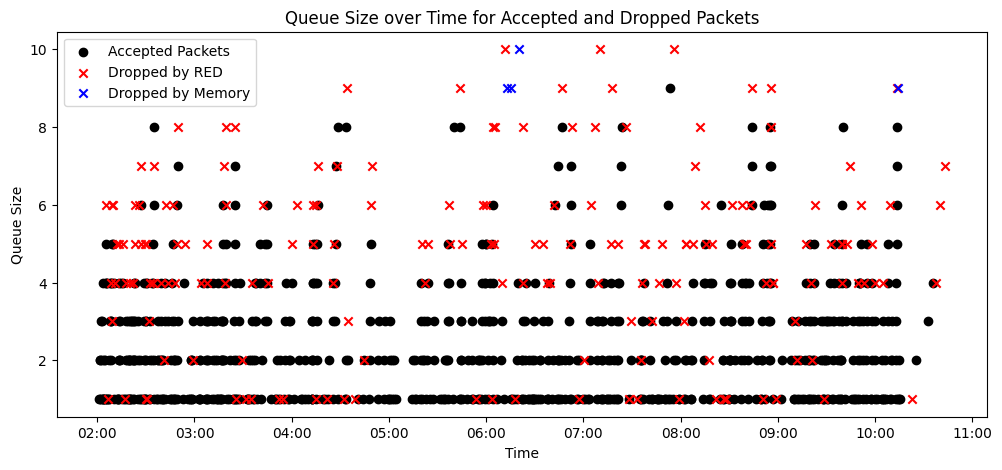

In [8]:
# Criar dicionário para mapear tempos ao tamanho da fila
queue_dict = {convert_time(t): v for t, v in queue_size_data}

# Pegar o tamanho da fila correspondente aos eventos
accepted_queue_sizes = [queue_dict.get(t, None) for t in accepted_packets]
dropped_red_queue_sizes = [queue_dict.get(t, None) for t in dropped_red]
dropped_memory_queue_sizes = [queue_dict.get(t, None) for t in dropped_memory]

# Criar o gráfico
plt.figure(figsize=(12, 5))

# Adicionar pacotes aceitos
plt.scatter(accepted_packets, accepted_queue_sizes, color='black', marker='o', label='Accepted Packets')

# Adicionar pacotes descartados pelo RED
plt.scatter(dropped_red, dropped_red_queue_sizes, color='red', marker='x', label='Dropped by RED')

# Adicionar pacotes descartados por falta de memória
plt.scatter(dropped_memory, dropped_memory_queue_sizes, color='blue', marker='x', label='Dropped by Memory')

# Configurar formato do eixo X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%M:%S"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Adicionar rótulos e legenda
plt.xlabel("Time")
plt.ylabel("Queue Size")
plt.legend()
plt.title("Queue Size over Time for Accepted and Dropped Packets")

# Mostrar o gráfico
plt.show()
